# Options Pricing Using Machine Learning

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [6]:
# Create a Ticker object
apple_ticker = yf.Ticker("AAPL")

# Fetch historical market data
apple_historical_data = apple_ticker.history(period="1y")  # data for the last year
print("Historical Data:")
print(apple_historical_data.head(5))

# Fetch basic financials
financials = apple_ticker.financials
print("\nFinancials:")
print(financials)

# Fetch stock actions like dividends and splits
actions = apple_ticker.actions
print("\nStock Actions:")
print(actions)


Historical Data:
                                 Open        High         Low       Close  \
Date                                                                        
2023-12-28 00:00:00-05:00  193.193544  193.711013  192.228271  192.636276   
2023-12-29 00:00:00-05:00  192.954701  193.452263  190.795282  191.591385   
2024-01-02 00:00:00-05:00  186.237603  187.521323  182.993502  184.734970   
2024-01-03 00:00:00-05:00  183.321893  184.973804  182.535736  183.351746   
2024-01-04 00:00:00-05:00  181.261998  182.197418  179.998201  181.023178   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-12-28 00:00:00-05:00  34049900        0.0           0.0  
2023-12-29 00:00:00-05:00  42628800        0.0           0.0  
2024-01-02 00:00:00-05:00  82488700        0.0           0.0  
2024-01-03 00:00:00-05:00  58414500        0.0           0.0  
2024-01-04 00:00:00-05:00  71983600        0.0           0.0  

F

In [7]:
# Fetch risk-free interest rate
rfir_array = yf.Ticker("^IRX").history(period="1y").Close

rfir = np.mean(rfir_array.values)

print(rfir)


4.963296415306362


In [8]:
apple=pd.DataFrame(apple_historical_data)
apple

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-28 00:00:00-05:00,193.193544,193.711013,192.228271,192.636276,34049900,0.0,0.0
2023-12-29 00:00:00-05:00,192.954701,193.452263,190.795282,191.591385,42628800,0.0,0.0
2024-01-02 00:00:00-05:00,186.237603,187.521323,182.993502,184.734970,82488700,0.0,0.0
2024-01-03 00:00:00-05:00,183.321893,184.973804,182.535736,183.351746,58414500,0.0,0.0
2024-01-04 00:00:00-05:00,181.261998,182.197418,179.998201,181.023178,71983600,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-20 00:00:00-05:00,248.039993,255.000000,245.690002,254.490005,147495300,0.0,0.0
2024-12-23 00:00:00-05:00,254.770004,255.649994,253.449997,255.270004,40858800,0.0,0.0
2024-12-24 00:00:00-05:00,255.490005,258.209991,255.289993,258.200012,23234700,0.0,0.0


In [9]:
# a baseline for predicting volatility
"""
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
"""

""" def volatilities(df, metric, n):

    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.var(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.var(df[(n-1)*interval:n*interval][metric]))
    return sigmas """

def volatilities(df, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.std(df[i-n:i]['Close']))
    sigmas = np.insert(sigmas, 0, np.full((n), 0))
    return sigmas


In [10]:
rolling_sigmas = volatilities(apple)

Apple announced their new M4 chips on 7 May, 2024. That seems to be about when the prices started to rise and maybe why the middle volatility is so large. These M4 chips use a different kind of architecture from Intel.

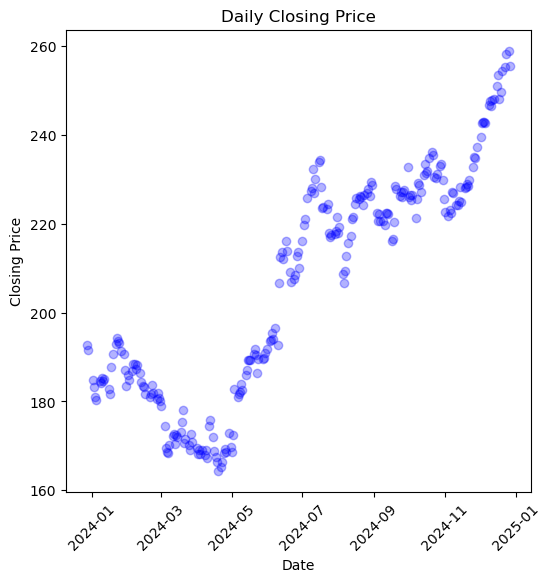

In [11]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(apple.index, apple['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

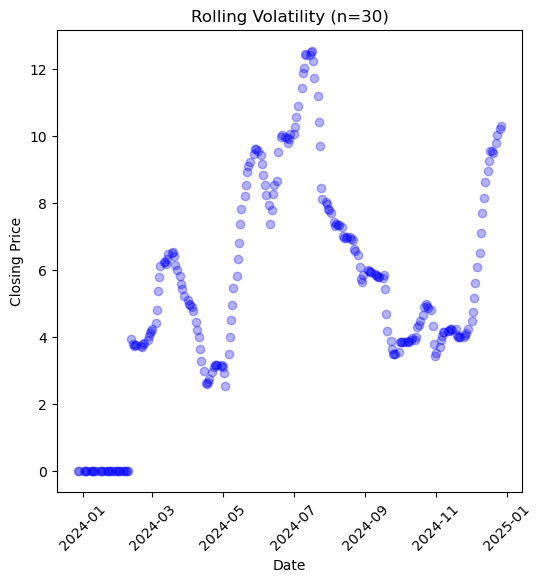

In [12]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(apple.index, rolling_sigmas, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=30)')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [13]:
# Preprocessing and feature engineering

expiration_dates = apple_ticker.options

apple_calls = pd.DataFrame()
apple_puts = pd.DataFrame()

# Download the options data for Apple for all expiration dates, put into 1 table
# Add columns for expiration date and time to expiration
for i in expiration_dates:
    apple_options = apple_ticker.option_chain(i)

    # Separate the calls and puts data
    new_call = pd.DataFrame(apple_options.calls)
    new_call.insert(0, 'Expiration_Date', np.full(len(new_call), pd.to_datetime(i)))
    new_call=new_call.dropna()
    new_call['TimeToExpiration'] = (pd.to_datetime(i) - pd.Timestamp.now()).days
    apple_calls = pd.concat([apple_calls, new_call])
    new_put = pd.DataFrame(apple_options.puts)
    new_put.insert(0, 'Expiration_Date', np.full(len(new_put), pd.to_datetime(i)))
    new_put=new_put.dropna()
    new_put['TimeToExpiration'] = (pd.to_datetime(i) - pd.Timestamp.now()).days
    apple_puts = pd.concat([apple_puts, new_put])
    
# Eliminate outliers in implied volatility

apple_calls = apple_calls[abs(apple_calls.impliedVolatility)<=apple_calls.impliedVolatility.std()*3]

In [14]:
apple_calls

,Expiration_Date,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,TimeToExpiration
2,2025-01-03,AAPL250103C00150000,2024-12-27 17:02:53+00:00,150.0,103.60,103.85,107.75,-0.580002,-0.556731,14.0,18,1.726564,True,REGULAR,USD,6
4,2025-01-03,AAPL250103C00160000,2024-12-27 20:01:22+00:00,160.0,95.60,94.50,97.15,1.309998,1.389328,5.0,2,1.562502,True,REGULAR,USD,6
5,2025-01-03,AAPL250103C00165000,2024-12-26 20:50:00+00:00,165.0,94.40,88.90,92.70,0.000000,0.000000,1.0,4,1.447268,True,REGULAR,USD,6
6,2025-01-03,AAPL250103C00170000,2024-12-20 15:50:12+00:00,170.0,85.65,83.90,87.75,5.480003,6.835479,1.0,7,1.380862,True,REGULAR,USD,6
8,2025-01-03,AAPL250103C00180000,2024-12-27 18:39:46+00:00,180.0,74.83,75.50,77.10,-3.430000,-4.382827,43.0,55,1.453128,True,REGULAR,USD,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2027-01-15,AAPL270115C00410000,2024-12-27 19:01:52+00:00,410.0,5.30,3.90,5.65,-0.150000,-2.752287,1.0,62,0.258156,False,REGULAR,USD,748
57,2027-01-15,AAPL270115C00420000,2024-12-27 16:24:51+00:00,420.0,4.40,3.95,5.00,0.120000,2.803736,3.0,3254,0.258491,False,REGULAR,USD,748
58,2027-01-15,AAPL270115C00430000,2024-12-24 15:12:34+00:00,430.0,4.00,2.92,4.50,0.000000,0.000000,1.0,22,0.259865,False,REGULAR,USD,748
59,2027-01-15,AAPL270115C00440000,2024-12-27 17:52:16+00:00,440.0,3.30,3.00,3.70,-0.200000,-5.714287,12.0,199,0.255684,False,REGULAR,USD,748


In [15]:
keep_cols = ['strike', 'lastPrice', 'bid', 'ask', 'percentChange', 'TimeToExpiration', 'impliedVolatility']
apple = apple_calls[keep_cols]

In [16]:
features = ['strike', 'lastPrice', 'TimeToExpiration', 'bid', 'ask', ]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(apple[features], apple.impliedVolatility, test_size=0.2, shuffle=True)

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

rf = RandomForestRegressor(n_estimators=100, max_depth=50)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(mean_squared_error(y_test, y_pred))

0.09958566755145784


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


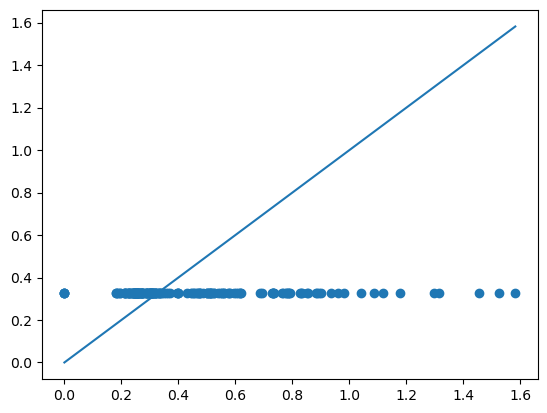

In [19]:
plt.scatter(y_test, y_pred)
plt.plot(np.linspace(np.amin(y_test), np.amax(y_test), num=10), np.linspace(np.amin(y_test), np.amax(y_test), num=10))
plt.show()

In [20]:
# Define the ticker symbol
ticker_symbol = "TSLA" # Tesla

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(period="1y")  # data for the last year
tesla = pd.DataFrame(historical_data)

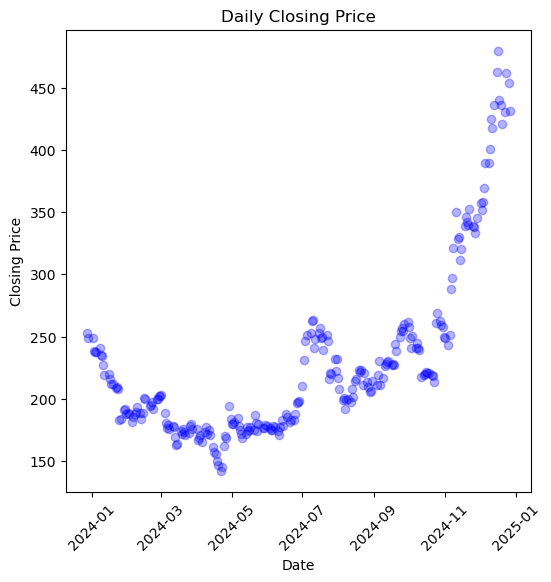

In [21]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(tesla.index, tesla['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [32]:
rolling_sigmas = volatilities(tesla)

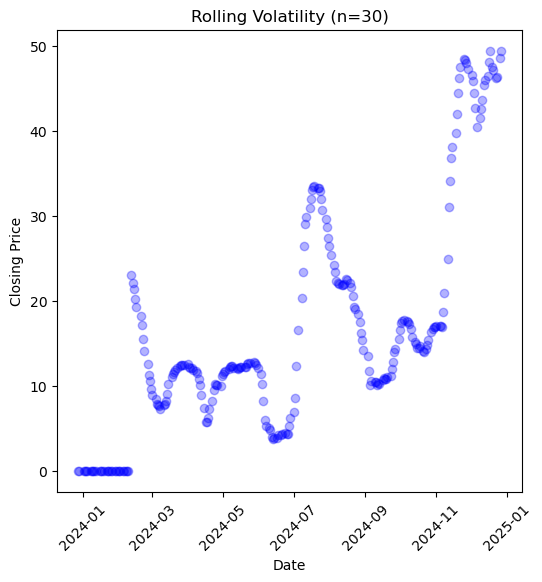

In [33]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.scatter(tesla.index, rolling_sigmas, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=30)')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

### Medium article

Below is some stuff from an [article](https://theaiquant.medium.com/mastering-option-pricing-with-machine-learning-a-practical-guide-to-valuing-real-options-data-1ef58c8d3a39).

In [23]:
# Define the ticker symbol for JPMorgan Chase & Co.
ticker_symbol = 'JPM'

# Initialize the yfinance Ticker object for JPM
jpm_ticker = yf.Ticker(ticker_symbol)

# Get available expiration dates
expiration_dates = jpm_ticker.options

# Choose an expiration date that exists in the list of available expiration dates
# For the purpose of this example, let's choose the first available expiration date
expiration_date = expiration_dates[0]

# Download the options data for JPM for the chosen expiration date
jpm_options = jpm_ticker.option_chain(expiration_date)

# Separate the calls and puts data
jpm_calls = jpm_options.calls
jpm_puts = jpm_options.puts

# Display the first few rows of the calls data
print(jpm_calls.head())

       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  JPM250103C00125000 2024-12-20 14:50:23+00:00   125.0     107.75  115.45   
1  JPM250103C00190000 2024-12-24 16:23:44+00:00   190.0      51.75   50.50   
2  JPM250103C00195000 2024-12-17 15:01:40+00:00   195.0      43.48   45.55   
3  JPM250103C00200000 2024-12-27 17:04:52+00:00   200.0      40.54   40.55   
4  JPM250103C00205000 2024-12-23 16:58:13+00:00   205.0      32.66   35.55   

     ask    change  percentChange  volume  openInterest  impliedVolatility  \
0  117.5  0.000000        0.00000     1.0             1           2.216801   
1   52.5  0.000000        0.00000     3.0             4           0.922852   
2   47.6  0.000000        0.00000     NaN             1           0.868654   
3   42.6 -2.259998       -5.28037     7.0             3           0.781740   
4   37.6  0.000000        0.00000    40.0            40           0.695804   

   inTheMoney contractSize currency  
0        True      REGUL

In [24]:
expiration_dates

('2025-01-03',
 '2025-01-10',
 '2025-01-17',
 '2025-01-24',
 '2025-01-31',
 '2025-02-21',
 '2025-03-21',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-12-18',
 '2027-01-15')

In [25]:
# Preprocessing and feature engineering for JPM calls data
# Assume similar steps for puts data and other assets

# Drop rows with missing values
jpm_calls_cleaned = jpm_calls.dropna()

# Feature engineering: calculate moneyness, time to expiration and other relevant features
# Assuming that 'lastPrice' represents the current stock price
jpm_calls_cleaned['Moneyness'] = jpm_calls_cleaned['lastPrice'] / jpm_calls_cleaned['strike']
jpm_calls_cleaned['TimeToExpiration'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days

# Display the first few rows of the processed calls data
print(jpm_calls_cleaned.head())

       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  JPM250103C00125000 2024-12-20 14:50:23+00:00   125.0     107.75  115.45   
1  JPM250103C00190000 2024-12-24 16:23:44+00:00   190.0      51.75   50.50   
3  JPM250103C00200000 2024-12-27 17:04:52+00:00   200.0      40.54   40.55   
4  JPM250103C00205000 2024-12-23 16:58:13+00:00   205.0      32.66   35.55   
5  JPM250103C00210000 2024-12-20 15:38:40+00:00   210.0      27.40   30.60   

     ask    change  percentChange  volume  openInterest  impliedVolatility  \
0  117.5  0.000000        0.00000     1.0             1           2.216801   
1   52.5  0.000000        0.00000     3.0             4           0.922852   
3   42.6 -2.259998       -5.28037     7.0             3           0.781740   
4   37.6  0.000000        0.00000    40.0            40           0.695804   
5   32.6  0.000000        0.00000   300.0           301           0.618168   

   inTheMoney contractSize currency  Moneyness  TimeToExpirati

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_70392/1641090000.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpm_calls_cleaned['Moneyness'] = jpm_calls_cleaned['lastPrice'] / jpm_calls_cleaned['strike']
/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_70392/1641090000.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpm_calls_cleaned['TimeToExpiration'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days


Text(0, 0.5, 'Frequency')

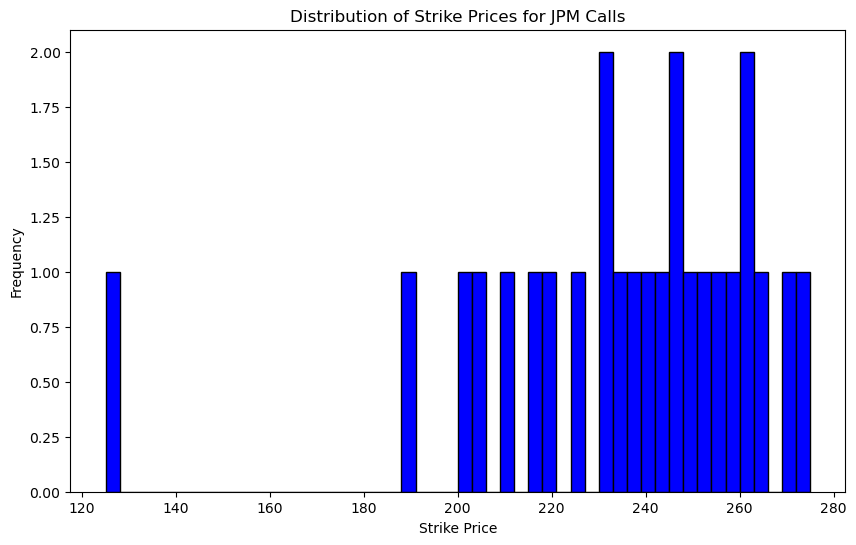

In [26]:
# Plot the distribution of strike prices for JPM calls
plt.figure(figsize=(10, 6))
plt.hist(jpm_calls_cleaned['strike'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Strike Prices for JPM Calls')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

In [27]:
jpm_calls_cleaned.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Moneyness,TimeToExpiration
0,JPM250103C00125000,2024-12-20 14:50:23+00:00,125.0,107.75,115.45,117.5,0.000000,0.00000,1.0,1,2.216801,True,REGULAR,USD,0.862000,6
1,JPM250103C00190000,2024-12-24 16:23:44+00:00,190.0,51.75,50.50,52.5,0.000000,0.00000,3.0,4,0.922852,True,REGULAR,USD,0.272368,6
3,JPM250103C00200000,2024-12-27 17:04:52+00:00,200.0,40.54,40.55,42.6,-2.259998,-5.28037,7.0,3,0.781740,True,REGULAR,USD,0.202700,6
4,JPM250103C00205000,2024-12-23 16:58:13+00:00,205.0,32.66,35.55,37.6,0.000000,0.00000,40.0,40,0.695804,True,REGULAR,USD,0.159317,6
5,JPM250103C00210000,2024-12-20 15:38:40+00:00,210.0,27.40,30.60,32.6,0.000000,0.00000,300.0,301,0.618168,True,REGULAR,USD,0.130476,6


In [28]:
# Prepare the data for training the machine learning model
X = jpm_calls_cleaned[['Moneyness','TimeToExpiration', 'impliedVolatility']]
y = jpm_calls_cleaned['lastPrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=200,random_state=30)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predict option prices on the test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 759.4642568289999


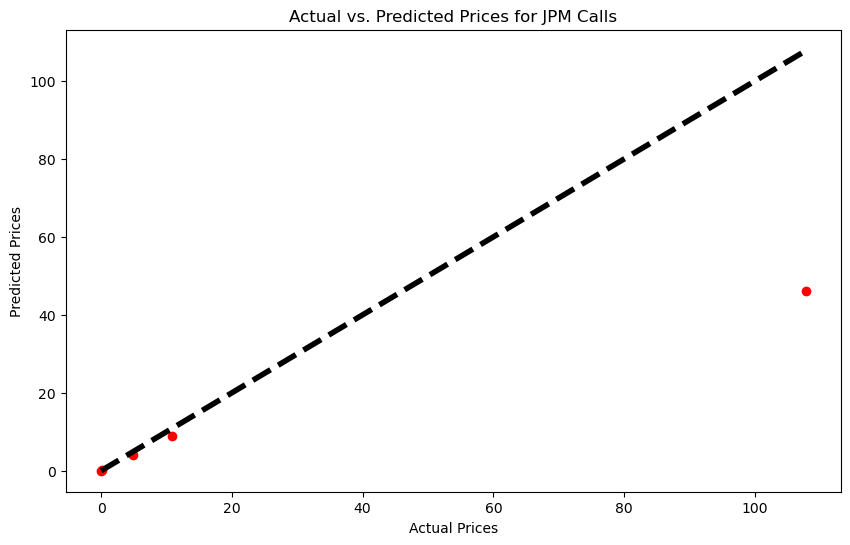

In [29]:
# Plot actual vs. predicted prices for JPM calls
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red')
plt.title('Actual vs. Predicted Prices for JPM Calls')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

Text(0, 0.5, 'Feature')

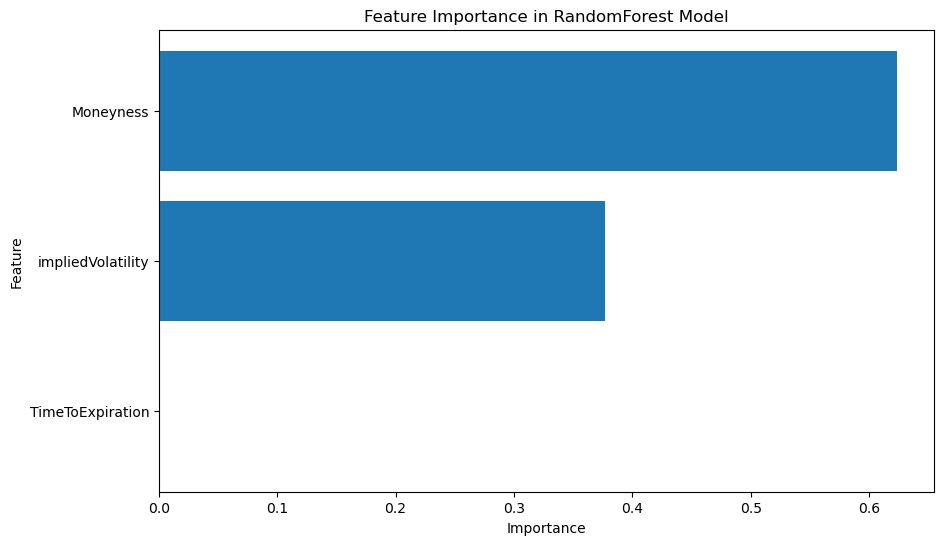

In [30]:
# Plot feature importance
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance in RandomForest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')